In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [5]:
openai_data = pd.read_parquet("./llm_data/rq3_validation_evidence_openai.parquet")
gemini_data = pd.read_parquet("./llm_data/rq3_validation_evidence_gemini.parquet")

In [6]:
openai_data.head()

,pr_id,author_type,repo,pr_number,pr_title,pipeline_names,validation_present,evidence_sources,validation_type,validation_description,pipeline_signal,description_signal,comment_signal
0,2766896431,ai_agent,onlook-dev/onlook,982,Replace motion library with Tailwind transitio...,[],True,[description],static-analysis,The PR explicitly states that performance is i...,"No performance benchmarks, profiling, or metri...",Description claims improved performance specif...,Comments do not discuss or provide any perform...
1,2843312341,ai_agent,promptfoo/promptfoo,3046,perf: optimize cache and token handling,"[CI, Validate PR Title]",False,[],none,The PR description claims performance optimiza...,Pipeline only validates PR title; no performan...,Description mentions performance-oriented chan...,"Comments discuss automation (Devin, TestGru) a..."
2,2843334531,ai_agent,promptfoo/promptfoo,3047,perf: optimize cache and token handling,"[CI, Validate PR Title]",True,[description],static-analysis,The PR description explicitly describes perfor...,CI only validates the PR title and does not pr...,The description claims performance optimizatio...,"Comments are from automation (Devin, TestGru) ..."
3,2855302194,ai_agent,pdfme/pdfme,711,Optimize Font Loading Performance in Tests,[Unit Testing],True,[description],benchmark,Performance is validated by reporting before-a...,CI pipeline lists unit testing but does not re...,PR description includes explicit before-and-af...,PR comments contain only bot/automation inform...
4,2859989652,ai_agent,wolfSSL/wolfssh,779,Update SFTP status callback to output once per...,"[Cppcheck Test, Kyber Tests, OS Check Test, Si...",False,[],none,The PR mentions only functional static analysi...,"CI pipelines listed (Cppcheck, OS Check, Zephy...",The description explains that status updates a...,Comments mention that there was a performance ...


In [7]:
len(openai_data), len(gemini_data)

(407, 407)

In [8]:
print("=== OPENAI DATA ===")
print(f"Rows: {len(openai_data)}")

print("Authors:", openai_data["author_type"].value_counts().to_dict())

print("validation_present counts:")
print(openai_data["validation_present"].value_counts(dropna=False))

print("validation_type counts:")
print(openai_data["validation_type"].value_counts(dropna=False))

=== OPENAI DATA ===
Rows: 407
Authors: {'ai_agent': 324, 'human': 83}
validation_present counts:
validation_present
True     221
False    186
Name: count, dtype: int64
validation_type counts:
validation_type
none               186
static-analysis    144
benchmark           65
anecdotal            6
profiling            6
Name: count, dtype: int64


In [6]:
print("\n=== GEMINI DATA ===")
print(f"Rows: {len(gemini_data)}")

print("Authors:", gemini_data["author_type"].value_counts().to_dict())

print("validation_present counts:")
print(gemini_data["validation_present"].value_counts(dropna=False))

print("validation_type counts:")
print(gemini_data["validation_type"].value_counts(dropna=False))


=== GEMINI DATA ===
Rows: 407
Authors: {'ai_agent': 324, 'human': 83}
validation_present counts:
validation_present
False    216
True     191
Name: count, dtype: int64
validation_type counts:
validation_type
none               216
static-analysis    109
benchmark           61
anecdotal           15
profiling            6
Name: count, dtype: int64


In [ ]:

    # ============================================================
    # Cohen's Kappa agreement between OpenAI and Gemini labels
    # ============================================================
    !pip3 install scikit-learn
    from sklearn.metrics import cohen_kappa_score
    from pathlib import Path

    def _compute_kappa_stats(openai_df, gemini_df, comparisons, candidate_keys=None):
        if candidate_keys is None:
            candidate_keys = [
                ["id"],
                ["issue_url"],
                ["html_url"],
                ["url"],
                ["pr_url"],
                ["pull_request_url"],
                ["pr_id"],
                ["repo_owner", "repo_name", "pr_number"],
                ["repo_owner", "repo", "pr_number"],
                ["repo_name", "pr_number"],
                ["repo", "pr_number"],
                ["repo", "pr_title"],
            ]

        def _has_all(df, cols):
            return all(col in df.columns for col in cols)

        key_cols = None
        for cols in candidate_keys:
            if _has_all(openai_df, cols) and _has_all(gemini_df, cols):
                key_cols = cols
                break

        if key_cols is None:
            shared = sorted(set(openai_df.columns) & set(gemini_df.columns))
            raise ValueError(f"No shared identifier columns found. Common columns: {shared}")

        subset_cols = list(dict.fromkeys(list(key_cols) + list(comparisons.keys())))
        merged = (
            openai_df[subset_cols]
            .merge(
                gemini_df[subset_cols],
                on=key_cols,
                suffixes=("_openai", "_gemini"),
                how="inner",
            )
        )

        stats = {}
        for col, normalizer in comparisons.items():
            left = normalizer(merged[f"{col}_openai"])
            right = normalizer(merged[f"{col}_gemini"])
            match_rate = float((left == right).mean()) if len(left) else float("nan")
            stats[col] = {
                "kappa": cohen_kappa_score(left, right),
                "match_rate": match_rate,
            }
        return key_cols, len(merged), stats

    def _build_overlap_dataframe(openai_df, gemini_df, key_cols, comparisons, extra_cols=None):
        if extra_cols is None:
            extra_cols = []
        subset_cols = list(dict.fromkeys(list(key_cols) + list(comparisons.keys()) + list(extra_cols)))
        openai_subset = openai_df.reindex(columns=subset_cols)
        gemini_subset = gemini_df.reindex(columns=subset_cols)
        merged = (
            openai_subset
            .merge(
                gemini_subset,
                on=key_cols,
                suffixes=("_openai", "_gemini"),
                how="inner",
            )
        )
        return merged

    def _combine_columns(df, column_name):
        base = df.get(column_name)
        left = df.get(f"{column_name}_openai")
        right = df.get(f"{column_name}_gemini")
        if left is None and base is not None:
            left = base
        if right is None and base is not None:
            right = base
        if left is None:
            left = pd.Series(pd.NA, index=df.index)
        if right is None:
            right = pd.Series(pd.NA, index=df.index)
        return left.where(left.notna(), right)


    def _group_author_label(label):
        value = "unknown"
        if label is not None:
            try:
                if not pd.isna(label):
                    value = str(label).strip().lower() or "unknown"
            except Exception:
                value = str(label).strip().lower() or "unknown"
        if "agent" in value:
            return "agent"
        if "human" in value:
            return "human"
        return value

    def _combine_candidates(df, candidates):
        combined = pd.Series(pd.NA, index=df.index)
        for candidate in candidates:
            series = _combine_columns(df, candidate)
            combined = combined.where(combined.notna(), series)
        return combined

    def _derive_html_url(row):
        current = row.get("html_url_combined")
        if isinstance(current, str) and current.strip():
            return current.strip()
        repo_value = row.get("repo_combined")
        repo_owner_value = row.get("repo_owner_combined")
        repo_name_value = row.get("repo_name_combined")
        pr_number_value = row.get("pr_number_combined")
        repo_path = ""
        if isinstance(repo_value, str) and repo_value.strip():
            repo_path = repo_value.strip().strip("/")
        elif isinstance(repo_owner_value, str) and repo_owner_value.strip() and isinstance(repo_name_value, str) and repo_name_value.strip():
            repo_path = f"{repo_owner_value.strip()}/{repo_name_value.strip()}".strip("/")
        pr_number_str = ""
        if isinstance(pr_number_value, str):
            pr_number_str = pr_number_value.strip()
        elif pr_number_value is not None and pd.notna(pr_number_value):
            try:
                pr_number_str = str(int(float(pr_number_value)))
            except Exception:
                pr_number_str = str(pr_number_value).strip()
        if repo_path and pr_number_str:
            return f"https://github.com/{repo_path}/pull/{pr_number_str}"
        return current

    def _normalize_author_type(df):
        df = df.copy()
        if "author_type" not in df.columns:
            df["author_type"] = "unknown"
        df["author_type"] = df["author_type"].fillna("unknown").astype(str)
        return df

    identifier_column_candidates = {
        "id": ["id", "pr_id", "pull_request_id", "issue_id"],
        "html_url": ["html_url", "issue_url", "url", "pr_url", "pull_request_url"],
        "repo": ["repo"],
        "repo_owner": ["repo_owner"],
        "repo_name": ["repo_name"],
        "pr_number": ["pr_number"],
    }

    comparison_columns = {
        "validation_present": lambda s: s.fillna(False).astype(bool),
        "validation_type": lambda s: s.fillna("none").astype(str).str.strip(),
    }

    openai_kappa_df = _normalize_author_type(openai_data)
    gemini_kappa_df = _normalize_author_type(gemini_data)

    kappa_keys, overlap_count, kappa_scores = _compute_kappa_stats(
        openai_kappa_df,
        gemini_kappa_df,
        comparison_columns,
    )

    def _print_stats(prefix, overlap, keys, stats):
        print(prefix)
        print(f"Identifier columns used: {keys}")
        print(f"Rows compared: {overlap}")
        for label, metrics in stats.items():
            kappa = metrics["kappa"]
            match_rate = metrics["match_rate"] * 100 if metrics["match_rate"] == metrics["match_rate"] else float("nan")
            print(f"  {label}: kappa={kappa:.4f}, match_rate={match_rate:.2f}%")

    _print_stats("Cohen's Kappa Agreement (OpenAI vs Gemini)", overlap_count, kappa_keys, kappa_scores)

    print("Per-author agreement:")
    author_values = sorted(set(openai_kappa_df["author_type"]).union(set(gemini_kappa_df["author_type"])))
    for author in author_values:
        left = openai_kappa_df[openai_kappa_df["author_type"] == author]
        right = gemini_kappa_df[gemini_kappa_df["author_type"] == author]
        try:
            a_keys, a_overlap, a_scores = _compute_kappa_stats(left, right, comparison_columns)
        except ValueError as exc:
            print(f"  author={author}: skipped ({exc})")
            continue

        if a_overlap == 0:
            print(f"  author={author}: no overlapping rows")
            continue

        print(f"  author={author}:")
        print(f"    rows compared={a_overlap}, identifiers={a_keys}")
        for label, metrics in a_scores.items():
            kappa = metrics["kappa"]
            match_rate = metrics["match_rate"] * 100 if metrics["match_rate"] == metrics["match_rate"] else float("nan")
            print(f"    {label}: kappa={kappa:.4f}, match_rate={match_rate:.2f}%")

    # Save unmatched rows for manual review per author type
    overlap_details = _build_overlap_dataframe(
        openai_kappa_df,
        gemini_kappa_df,
        kappa_keys,
        comparison_columns,
        extra_cols=list(dict.fromkeys(["author_type"] + sum(identifier_column_candidates.values(), []))),
    )

    mismatch_mask = pd.Series(False, index=overlap_details.index)
    for col, normalizer in comparison_columns.items():
        left = normalizer(overlap_details[f"{col}_openai"])
        right = normalizer(overlap_details[f"{col}_gemini"])
        mismatch_mask = mismatch_mask | (left != right)

    unmatched_rows = overlap_details[mismatch_mask].copy()
    unmatched_rows["author_type_combined"] = _combine_columns(unmatched_rows, "author_type").fillna("unknown")
    unmatched_rows["id_combined"] = _combine_candidates(unmatched_rows, identifier_column_candidates["id"])
    unmatched_rows["html_url_combined"] = _combine_candidates(unmatched_rows, identifier_column_candidates["html_url"])
    unmatched_rows["repo_combined"] = _combine_candidates(unmatched_rows, identifier_column_candidates.get("repo", []))
    unmatched_rows["repo_owner_combined"] = _combine_candidates(unmatched_rows, identifier_column_candidates.get("repo_owner", []))
    unmatched_rows["repo_name_combined"] = _combine_candidates(unmatched_rows, identifier_column_candidates.get("repo_name", []))
    unmatched_rows["pr_number_combined"] = _combine_candidates(unmatched_rows, identifier_column_candidates.get("pr_number", []))
    unmatched_rows["html_url_filled"] = unmatched_rows.apply(_derive_html_url, axis=1)
    unmatched_rows["author_type_normalized"] = unmatched_rows["author_type_combined"].fillna("unknown").str.strip().str.lower()
    unmatched_rows["author_type_grouped"] = unmatched_rows["author_type_normalized"].apply(_group_author_label)

    output_dir = Path("results")
    output_dir.mkdir(parents=True, exist_ok=True)

    output_map = {
        "human": output_dir / "rq3_openai_gemini_unmatched_human.csv",
        "agent": output_dir / "rq3_openai_gemini_unmatched_agent.csv",
    }

    for author_key, output_path in output_map.items():
        subset = unmatched_rows[unmatched_rows["author_type_grouped"] == author_key]
        export_df = subset.loc[:, ["id_combined", "html_url_filled"]].rename(columns={"id_combined": "id", "html_url_filled": "html_url"})
        export_df.to_csv(output_path, index=False)
        print(f"Saved {len(export_df)} unmatched rows for {author_key} authors to {output_path}")


[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [12]:
# ============================================================
# Cohen's Kappa agreement between manual human label sets
# ============================================================
from pathlib import Path

manual_label_dir = Path('manual_label')

manual_label_sets = {
    'human labels': (
        manual_label_dir / 'Antonio_Human_PRs.csv',
        manual_label_dir / 'Huiyun_Human_PRs.csv',
    ),
    'agent labels': (
        manual_label_dir / 'Antonio_Agent_PRs.csv',
        manual_label_dir / 'Huiyun_Agent_PRs.csv',
    ),
}


def _load_manual_labels(csv_path):
    df = pd.read_csv(csv_path)
    df.columns = [col.strip().lower() for col in df.columns]
    if 'validation_present' in df.columns:
        normalized = (
            df['validation_present']
            .astype(str)
            .str.strip()
            .str.lower()
        )
        df['validation_present'] = normalized.map({'true': True, 'false': False, '1': True, '0': False}).fillna(False)
    else:
        df['validation_present'] = False
    if 'validation_type' not in df.columns:
        df['validation_type'] = 'none'
    df['validation_type'] = df['validation_type'].fillna('none').astype(str).str.strip()
    return df


manual_comparisons = {
    'validation_present': lambda s: s.fillna(False).astype(bool),
    'validation_type': lambda s: s.fillna('none').astype(str).str.strip(),
}

loaded_manual_pairs = {}

for label_name, (antonio_path, huiyun_path) in manual_label_sets.items():
    antonio_df = _load_manual_labels(antonio_path)
    huiyun_df = _load_manual_labels(huiyun_path)

    manual_kappa_keys, manual_overlap_count, manual_kappa_scores = _compute_kappa_stats(
        antonio_df,
        huiyun_df,
        manual_comparisons,
        candidate_keys=[["id"], ["url"]],
    )

    loaded_manual_pairs[label_name] = (antonio_df, huiyun_df)

    _print_stats(
        f"Cohen's Kappa Agreement (Antonio vs Huiyun {label_name})",
        manual_overlap_count,
        manual_kappa_keys,
        manual_kappa_scores,
    )

combined_antonio_df = pd.concat([pair[0] for pair in loaded_manual_pairs.values()], ignore_index=True)
combined_huiyun_df = pd.concat([pair[1] for pair in loaded_manual_pairs.values()], ignore_index=True)

combined_kappa_keys, combined_overlap_count, combined_kappa_scores = _compute_kappa_stats(
    combined_antonio_df,
    combined_huiyun_df,
    manual_comparisons,
    candidate_keys=[["id"], ["url"]],
)

_print_stats(
    "Cohen's Kappa Agreement (Antonio vs Huiyun combined human + agent labels)",
    combined_overlap_count,
    combined_kappa_keys,
    combined_kappa_scores,
)


Cohen's Kappa Agreement (Antonio vs Huiyun human labels)
Identifier columns used: ['id']
Rows compared: 10
  validation_present: kappa=0.6154, match_rate=80.00%
  validation_type: kappa=0.5000, match_rate=70.00%
Cohen's Kappa Agreement (Antonio vs Huiyun agent labels)
Identifier columns used: ['id']
Rows compared: 53
  validation_present: kappa=0.4914, match_rate=81.13%
  validation_type: kappa=0.4895, match_rate=79.25%
Cohen's Kappa Agreement (Antonio vs Huiyun combined human + agent labels)
Identifier columns used: ['id']
Rows compared: 63
  validation_present: kappa=0.5333, match_rate=80.95%
  validation_type: kappa=0.5111, match_rate=77.78%


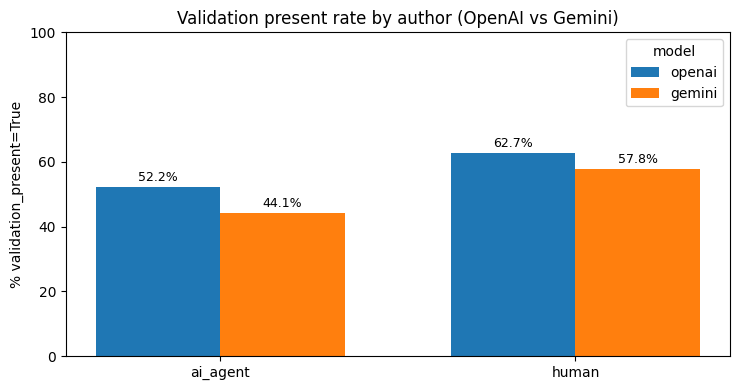

In [11]:
# ============================================================
# 1) ONE FIGURE: Validation present rate (OpenAI vs Gemini)
#    Grouped bars by author_type
#    Assumes you already have:
#      openai_data, gemini_data
# ============================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

AUTHOR_ORDER = ["ai_agent", "human"]

def _norm_present(df, model_name):
    df = df.copy()
    df["model"] = model_name
    if "author_type" not in df.columns:
        df["author_type"] = "unknown"
    if "validation_type" not in df.columns:
        df["validation_type"] = "none"
    if "validation_present" not in df.columns:
        df["validation_present"] = np.nan

    df["author_type"] = df["author_type"].fillna("unknown").astype(str)
    df["validation_type"] = df["validation_type"].fillna("none").astype(str)
    df["validation_present"] = df["validation_present"].fillna(df["validation_type"].ne("none"))
    df["validation_present"] = df["validation_present"].astype(bool)
    return df

openai_df = _norm_present(openai_data, "openai")
gemini_df = _norm_present(gemini_data, "gemini")
all_df = pd.concat([openai_df, gemini_df], ignore_index=True)
all_df = all_df[all_df["author_type"].isin(AUTHOR_ORDER)].copy()

present_rate = (
    all_df.groupby(["model", "author_type"])["validation_present"]
    .mean()
    .mul(100)
    .unstack()
    .reindex(index=["openai", "gemini"])
    .reindex(columns=AUTHOR_ORDER)
)

# ---- Plot grouped bars (one figure) ----
x = np.arange(len(AUTHOR_ORDER))
width = 0.35

fig, ax = plt.subplots(figsize=(7.5, 4))
ax.bar(x - width/2, present_rate.loc["openai"].values, width, label="openai")
ax.bar(x + width/2, present_rate.loc["gemini"].values, width, label="gemini")

ax.set_title("Validation present rate by author (OpenAI vs Gemini)")
ax.set_ylabel("% validation_present=True")
ax.set_xticks(x)
ax.set_xticklabels(AUTHOR_ORDER)
ax.set_ylim(0, 100)
ax.legend(title="model")

# labels
for i, v in enumerate(present_rate.loc["openai"].values):
    ax.text(i - width/2, v + 1, f"{v:.1f}%", ha="center", va="bottom", fontsize=9)
for i, v in enumerate(present_rate.loc["gemini"].values):
    ax.text(i + width/2, v + 1, f"{v:.1f}%", ha="center", va="bottom", fontsize=9)

plt.tight_layout()
plt.show()

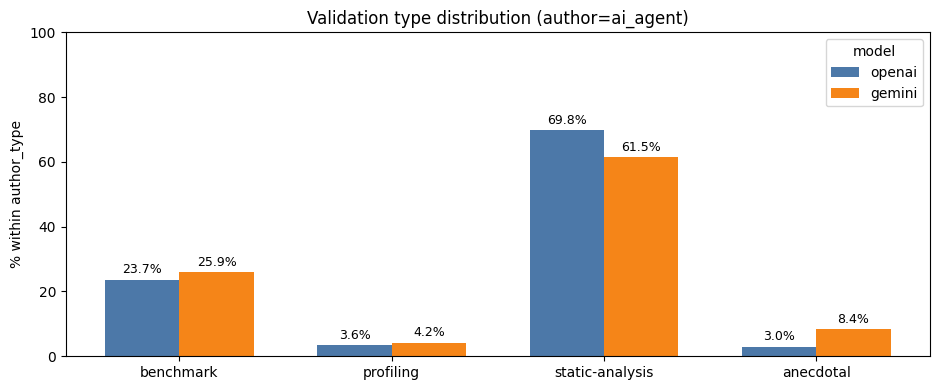

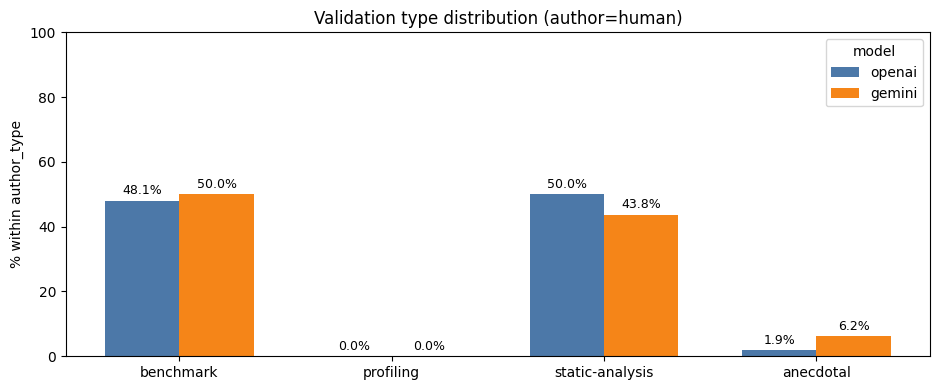

In [14]:
# ============================================================
# 2) SPLIT FIGURE: Validation type distribution
#    Two separate charts:
#      - author = ai_agent
#      - author = human
#    Grouped bars: OpenAI vs Gemini across validation types
#    SAME COLORS as your evidence-source chart
#
# Assumes you already have:
#   openai_data, gemini_data
# ============================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

VALIDATION_ORDER = [
    "benchmark",
    "profiling",
    "static-analysis",
    "anecdotal",
]
AUTHOR_ORDER = ["ai_agent", "human"]

OPENAI_COLOR = "#4c78a8"
GEMINI_COLOR = "#f58518"

def _norm_types(df, model_name):
    df = df.copy()
    df["model"] = model_name
    if "author_type" not in df.columns:
        df["author_type"] = "unknown"
    if "validation_type" not in df.columns:
        df["validation_type"] = "none"

    df["author_type"] = df["author_type"].fillna("unknown").astype(str)
    df["validation_type"] = df["validation_type"].fillna("none").astype(str)
    return df

openai_df = _norm_types(openai_data, "openai")
gemini_df = _norm_types(gemini_data, "gemini")
all_df = pd.concat([openai_df, gemini_df], ignore_index=True)
all_df = all_df[all_df["author_type"].isin(AUTHOR_ORDER)].copy()

# counts -> pct within (model, author)
counts = (
    all_df.groupby(["model", "author_type", "validation_type"])
    .size()
    .unstack(fill_value=0)
)

for t in VALIDATION_ORDER:
    if t not in counts.columns:
        counts[t] = 0
counts = counts[VALIDATION_ORDER]

pct = counts.div(counts.sum(axis=1).replace(0, np.nan), axis=0).mul(100)

def plot_validation_type_for_author(author: str):
    openai_vals = (
        pct.loc[("openai", author)].reindex(VALIDATION_ORDER).values
        if ("openai", author) in pct.index else np.zeros(len(VALIDATION_ORDER))
    )
    gemini_vals = (
        pct.loc[("gemini", author)].reindex(VALIDATION_ORDER).values
        if ("gemini", author) in pct.index else np.zeros(len(VALIDATION_ORDER))
    )

    x = np.arange(len(VALIDATION_ORDER))
    width = 0.35

    fig, ax = plt.subplots(figsize=(9.5, 4))

    ax.bar(x - width/2, openai_vals, width, label="openai", color=OPENAI_COLOR)
    ax.bar(x + width/2, gemini_vals, width, label="gemini", color=GEMINI_COLOR)

    ax.set_title(f"Validation type distribution (author={author})")
    ax.set_ylabel("% within author_type")
    ax.set_xlabel("")
    ax.set_xticks(x)
    ax.set_xticklabels(VALIDATION_ORDER)
    ax.set_ylim(0, 100)
    ax.legend(title="model")

    # Percentage labels
    for i, v in enumerate(openai_vals):
        ax.text(i - width/2, v + 1, f"{v:.1f}%", ha="center", va="bottom", fontsize=9)
    for i, v in enumerate(gemini_vals):
        ax.text(i + width/2, v + 1, f"{v:.1f}%", ha="center", va="bottom", fontsize=9)

    plt.tight_layout()
    plt.show()

# Two separate figures
plot_validation_type_for_author("ai_agent")
plot_validation_type_for_author("human")

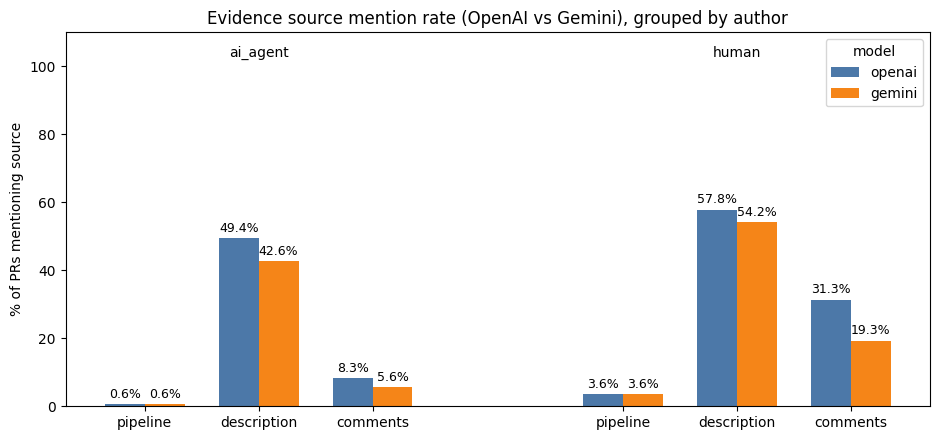

In [15]:
# ============================================================
# 3) ONE FIGURE: Evidence source (OpenAI vs Gemini)
#    Grouped bars by author_type
#    Metric: % of PRs that mention each source
#    SAME COLORS per model (consistent)
#    Assumes you already have:
#      openai_data, gemini_data
# ============================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

AUTHOR_ORDER = ["ai_agent", "human"]
SOURCE_ORDER = ["pipeline", "description", "comments"]

# ✅ Set consistent colors per model
OPENAI_COLOR = "#4c78a8"
GEMINI_COLOR = "#f58518"

def _norm_sources(df, model_name):
    df = df.copy()
    df["model"] = model_name

    if "author_type" not in df.columns:
        df["author_type"] = "unknown"
    if "evidence_sources" not in df.columns:
        df["evidence_sources"] = np.nan

    df["author_type"] = df["author_type"].fillna("unknown").astype(str)

    def to_list(x):
        if isinstance(x, list):
            return x
        if isinstance(x, tuple):
            return list(x)
        if isinstance(x, np.ndarray):
            return x.tolist()
        # only call pd.isna on scalar-like values to avoid ambiguous truth for arrays
        if not isinstance(x, (list, tuple, np.ndarray)) and pd.isna(x):
            return []
        if isinstance(x, str):
            s = x.strip()
            if s.startswith("[") and s.endswith("]"):
                inner = s[1:-1].strip()
                if not inner:
                    return []
                return [p.strip().strip("'").strip('"') for p in inner.split(",")]
            return [s]
        return []

    df["evidence_sources"] = df["evidence_sources"].apply(to_list)
    return df

openai_df = _norm_sources(openai_data, "openai")
gemini_df = _norm_sources(gemini_data, "gemini")
all_df = pd.concat([openai_df, gemini_df], ignore_index=True)
all_df = all_df[all_df["author_type"].isin(AUTHOR_ORDER)].copy()

# Create boolean flags per source
flags = pd.DataFrame({
    "pipeline": all_df["evidence_sources"].apply(lambda xs: "pipeline" in xs),
    "description": all_df["evidence_sources"].apply(lambda xs: "description" in xs),
    "comments": all_df["evidence_sources"].apply(lambda xs: "comments" in xs),
})
flags = pd.concat([all_df[["model", "author_type"]].reset_index(drop=True), flags], axis=1)

# % of PRs mentioning each source, within (model, author)
ev_rate = (
    flags.groupby(["model", "author_type"])[SOURCE_ORDER]
    .mean()
    .mul(100)
)

# Plot setup:
# x-axis categories = sources, repeated per author block
fig, ax = plt.subplots(figsize=(9.5, 4.5))

n_sources = len(SOURCE_ORDER)
gap = 1.2
block_width = n_sources + gap
width = 0.35

for a_idx, author in enumerate(AUTHOR_ORDER):
    base = a_idx * block_width
    xs = np.arange(n_sources) + base

    openai_vals = (
        ev_rate.loc[("openai", author)].reindex(SOURCE_ORDER).values
        if ("openai", author) in ev_rate.index else np.zeros(n_sources)
    )
    gemini_vals = (
        ev_rate.loc[("gemini", author)].reindex(SOURCE_ORDER).values
        if ("gemini", author) in ev_rate.index else np.zeros(n_sources)
    )

    ax.bar(
        xs - width/2, openai_vals, width,
        label="openai" if a_idx == 0 else None,
        color=OPENAI_COLOR
    )
    ax.bar(
        xs + width/2, gemini_vals, width,
        label="gemini" if a_idx == 0 else None,
        color=GEMINI_COLOR
    )

    ax.text(xs.mean(), 102, author, ha="center", va="bottom", fontsize=10)

# ticks
xticks = []
xlabels = []
for a_idx, author in enumerate(AUTHOR_ORDER):
    base = a_idx * block_width
    xs = np.arange(n_sources) + base
    xticks.extend(xs.tolist())
    xlabels.extend(SOURCE_ORDER)

ax.set_xticks(xticks)
ax.set_xticklabels(xlabels)
ax.set_ylabel("% of PRs mentioning source")
ax.set_title("Evidence source mention rate (OpenAI vs Gemini), grouped by author")
ax.set_ylim(0, 110)
ax.legend(title="model")

# labels
for p in ax.patches:
    h = p.get_height()
    ax.text(
        p.get_x() + p.get_width()/2, h + 1,
        f"{h:.1f}%", ha="center", va="bottom", fontsize=9
    )

plt.tight_layout()
plt.show()